# Traveling Salesman Problem (TSP) mit Evolutionären Algorithmen

## Einführung in Computational Intelligence

Dieses Notebook demonstriert die Anwendung eines **evolutionären Algorithmus (EA)** zur Lösung des klassischen Traveling Salesman Problems. Es wurde für Präsentations- und Prüfungszwecke erstellt.

---

## 1. Das TSP als kombinatorisches Optimierungsproblem

### Definition

Das **Traveling Salesman Problem (TSP)** ist eines der bekanntesten Probleme der kombinatorischen Optimierung:

> *Ein Handlungsreisender muss **n Städte** genau einmal besuchen und zum Ausgangspunkt zurückkehren. Gesucht ist die Route mit der **minimalen Gesamtdistanz**.*

### Warum ist das TSP so schwierig?

Das TSP gehört zur Klasse der **NP-harten Probleme**. Das bedeutet:

- Es gibt keinen bekannten Algorithmus, der das Problem in polynomieller Zeit exakt löst
- Die Anzahl möglicher Routen wächst **faktoriell**: $(n-1)!/2$ verschiedene Rundreisen
- Bei nur 20 Städten gibt es bereits über **60 Billiarden** mögliche Routen!

| Städte (n) | Mögliche Routen | Rechenzeit bei 1 Mio. Routen/s |
|------------|-----------------|-------------------------------|
| 6          | 60              | < 1 ms                        |
| 10         | 181.440         | < 1 s                         |
| 15         | 43 Milliarden   | ~12 Stunden                   |
| 20         | 60 Billiarden   | ~1.900 Jahre                  |

**Fazit:** Analytische/exakte Methoden scheitern bei steigender Städteanzahl → Heuristische Verfahren wie EAs sind notwendig!


In [50]:
# Bibliotheken importieren
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import random
import math
import os
import warnings
warnings.filterwarnings('ignore')

# Globaler Seed für Reproduzierbarkeit
# Ändere diesen Wert, um unterschiedliche zufällige Ergebnisse zu erhalten
GLOBAL_SEED = 4637

# Anzahl der Generationen (global einstellbar)
# Reduziere diesen Wert für bessere Übersichtlichkeit der Grafiken
N_GENERATIONS = 20

# Zufallsgenerator initialisieren
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)

# Matplotlib Stil setzen
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Export-Verzeichnis erstellen
EXPORT_DIR = 'files'
os.makedirs(EXPORT_DIR, exist_ok=True)

def save_figure(fig, filename, dpi=300):
    """Speichert eine Figur im Export-Verzeichnis."""
    filepath = os.path.join(EXPORT_DIR, filename)
    fig.savefig(filepath, dpi=dpi, bbox_inches='tight')
    print(f"  → Grafik gespeichert: {filepath}")

def save_table(df, filename, format='csv'):
    """Speichert eine Tabelle im Export-Verzeichnis."""
    filepath = os.path.join(EXPORT_DIR, filename)
    if format == 'csv':
        df.to_csv(filepath, index=True, encoding='utf-8')
    elif format == 'excel':
        df.to_excel(filepath, index=True)
    print(f"  → Tabelle gespeichert: {filepath}")

print("✓ Alle Bibliotheken erfolgreich geladen!")
print(f"✓ Export-Verzeichnis erstellt: {EXPORT_DIR}/")


✓ Alle Bibliotheken erfolgreich geladen!
✓ Export-Verzeichnis erstellt: files/


### Unser Beispiel: 6 Städte im Rheinland

Wir verwenden 6 reale Städte im Rheinland mit ihren ungefähren geografischen Koordinaten (Längen- und Breitengrad):


In [51]:
# Definition der Städte im Rheinland (Längengrad, Breitengrad)
# Koordinaten sind approximiert für bessere Visualisierung

cities = {
    'Köln':       (6.9578, 50.9367),
    'Bonn':       (7.0982, 50.7374),
    'Düsseldorf': (6.7763, 51.2254),
    'Aachen':     (6.0839, 50.7753),
    'Wuppertal':  (7.1833, 51.2562),
    'Leverkusen': (6.9847, 51.0459),
    'Düren':       (6.4816, 50.8032),
    'Euskirchen': (6.7886, 50.6606),
}



# Städtenamen und Koordinaten extrahieren
city_names = list(cities.keys())
city_coords = np.array(list(cities.values()))

def create_random_route(n_cities):
    """Erstellt eine zufällige Route (Permutation)."""
    route = list(range(n_cities))
    np.random.shuffle(route)
    return np.array(route)

print("Städte im Rheinland:")
print("-" * 40)
for i, (name, coords) in enumerate(cities.items()):
    print(f"{i}: {name:12} → ({coords[0]:.4f}°, {coords[1]:.4f}°)")


Städte im Rheinland:
----------------------------------------
0: Köln         → (6.9578°, 50.9367°)
1: Bonn         → (7.0982°, 50.7374°)
2: Düsseldorf   → (6.7763°, 51.2254°)
3: Aachen       → (6.0839°, 50.7753°)
4: Wuppertal    → (7.1833°, 51.2562°)
5: Leverkusen   → (6.9847°, 51.0459°)
6: Düren        → (6.4816°, 50.8032°)
7: Euskirchen   → (6.7886°, 50.6606°)


  → Grafik gespeichert: files/01_staedte_streudiagramm.png


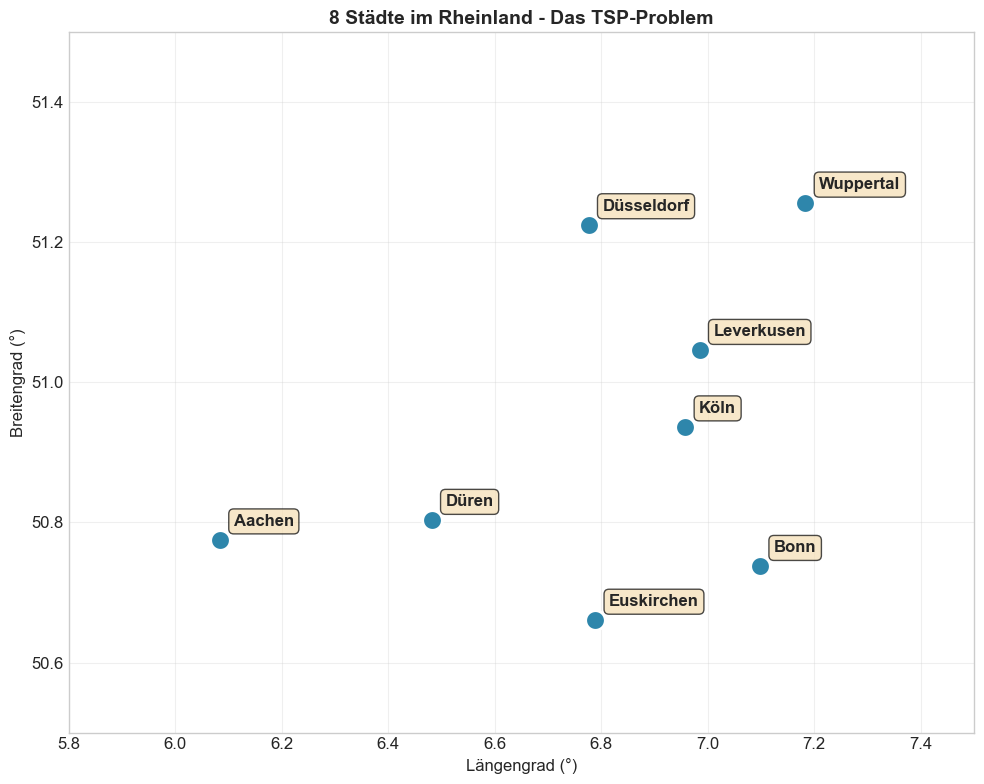


→ Anzahl möglicher Rundreisen: 2520 (bei 8 Städten)


In [52]:
# Visualisierung: Streudiagramm der Städte
fig, ax = plt.subplots(figsize=(10, 8))

# Städte als Punkte plotten
ax.scatter(city_coords[:, 0], city_coords[:, 1], 
           s=200, c='#2E86AB', edgecolors='white', linewidths=2, zorder=5)

# Städtenamen beschriften
for i, name in enumerate(city_names):
    ax.annotate(name, (city_coords[i, 0], city_coords[i, 1]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.7))

ax.set_xlabel('Längengrad (°)', fontsize=12)
ax.set_ylabel('Breitengrad (°)', fontsize=12)
stadt_anzahl = len(cities)
ax.set_title(f'{stadt_anzahl} Städte im Rheinland - Das TSP-Problem', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Achsenlimits anpassen
ax.set_xlim(5.8, 7.5)
ax.set_ylim(50.5, 51.5)

plt.tight_layout()
save_figure(fig, '01_staedte_streudiagramm.png')
plt.show()

print(f"\n→ Anzahl möglicher Rundreisen: {math.factorial(len(cities)-1)//2} (bei {len(cities)} Städten)")


---

## 2. Kodierung (Encoding): Die Permutationsdarstellung

### Genotyp vs. Phänotyp

In der Evolutionsbiologie und bei evolutionären Algorithmen unterscheiden wir:

| Begriff | Biologie | EA / TSP |
|---------|----------|----------|
| **Genotyp** | DNA-Sequenz | Die Zahlenliste im Code (eine Permutation der Städte-Indizes) |
| **Phänotyp** | Äußere Erscheinung | Die tatsächliche Route auf der Karte |

### Warum Permutationsdarstellung?

Beim TSP muss jede Stadt **genau einmal** besucht werden. Deshalb verwenden wir eine **Permutation** der Städte-Indizes:

- Ein Individuum = Eine Zahlenfolge der Länge n
- Jede Zahl kommt **genau einmal** vor
- Die Reihenfolge definiert die Besuchsreihenfolge

**Beispiel:** Eine Permutation wie `[a, b, c, d, e, f]` (mit Indizes 0-5) definiert die Besuchsreihenfolge der Städte. Das konkrete Beispiel wird in der nächsten Zelle generiert.

### Warum kein Binärstring?

Ein Binärstring (z.B. `101011...`) wäre hier **ungeeignet**, weil:
1. Er nicht garantiert, dass jede Stadt genau einmal besucht wird
2. Reparaturmechanismen nötig wären (aufwendig und fehleranfällig)
3. Die meisten generierten Strings ungültige Lösungen wären

**Merke:** Ein gutes Encoding muss den **gesamten Suchraum** abbilden können – jede gültige Permutation ist eine gültige Route!


In [53]:
# Beispiel: Ein Individuum als Permutation (Genotyp)
# Wird aus dem GLOBAL_SEED generiert - ändere den Seed für andere Beispiele!
example_genotype = list(create_random_route(len(city_names)))

print("GENOTYP (Code-Repräsentation):")
print(f"  Route = {example_genotype}")
print()
print("PHÄNOTYP (Interpretation):")
route_names = [city_names[i] for i in example_genotype]
print(f"  {' → '.join(route_names)} → {route_names[0]}")
print()
print("Städte-Index-Zuordnung:")
for i, name in enumerate(city_names):
    print(f"  {i} = {name}")


GENOTYP (Code-Repräsentation):
  Route = [0, 6, 2, 5, 3, 1, 4, 7]

PHÄNOTYP (Interpretation):
  Köln → Düren → Düsseldorf → Leverkusen → Aachen → Bonn → Wuppertal → Euskirchen → Köln

Städte-Index-Zuordnung:
  0 = Köln
  1 = Bonn
  2 = Düsseldorf
  3 = Aachen
  4 = Wuppertal
  5 = Leverkusen
  6 = Düren
  7 = Euskirchen


  → Grafik gespeichert: files/02_genotyp_phaenotyp_route.png


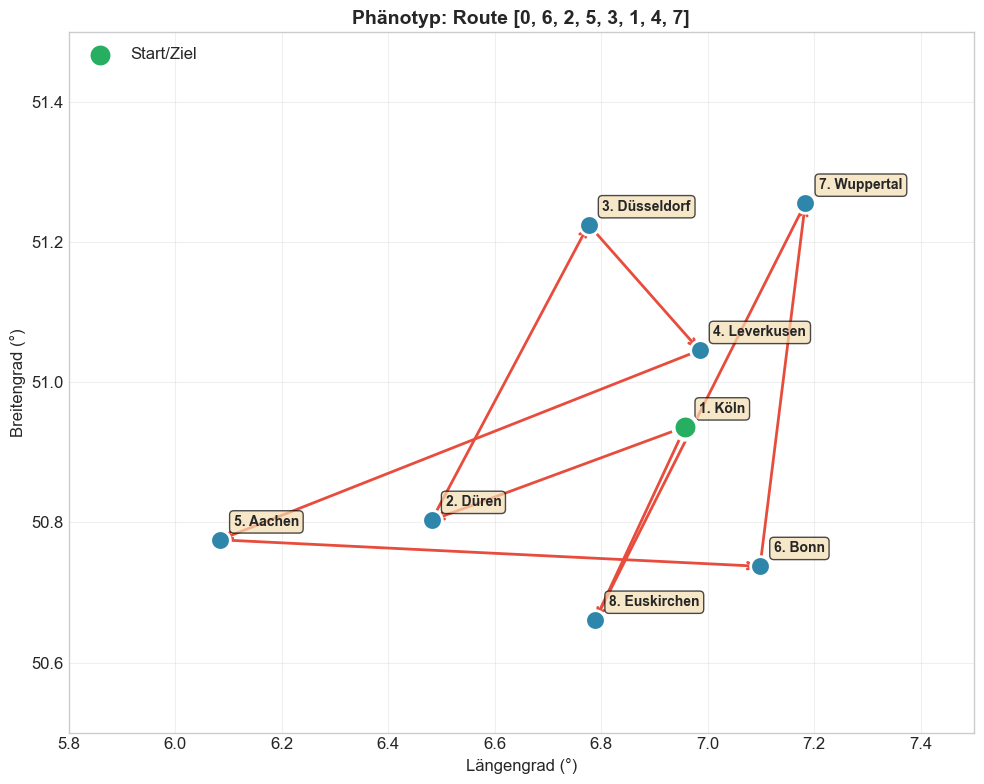

In [54]:
def plot_route(route, coords, names, title="TSP Route", ax=None):
    """Visualisiert eine Route als Phänotyp auf der Karte."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Route-Koordinaten in der richtigen Reihenfolge
    route_coords = coords[route]
    
    # Städte plotten
    ax.scatter(coords[:, 0], coords[:, 1], 
               s=200, c='#2E86AB', edgecolors='white', linewidths=2, zorder=5)
    
    # Route als Linien zeichnen (inkl. Rückweg zur Startstadt)
    for i in range(len(route)):
        start = route_coords[i]
        end = route_coords[(i + 1) % len(route)]
        ax.annotate('', xy=end, xytext=start,
                   arrowprops=dict(arrowstyle='->', color='#E74C3C', lw=2))
    
    # Startpunkt hervorheben
    ax.scatter(route_coords[0, 0], route_coords[0, 1], 
               s=300, c='#27AE60', edgecolors='white', linewidths=3, zorder=6,
               label='Start/Ziel')
    
    # Städtenamen beschriften
    for i, name in enumerate(names):
        ax.annotate(f"{route.tolist().index(i) + 1}. {name}" if i in route else name,
                   (coords[i, 0], coords[i, 1]),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.7))
    
    ax.set_xlabel('Längengrad (°)')
    ax.set_ylabel('Breitengrad (°)')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(5.8, 7.5)
    ax.set_ylim(50.5, 51.5)
    
    return ax

# Beispielroute visualisieren
route = np.array(example_genotype)
fig, ax = plt.subplots(figsize=(10, 8))
plot_route(route, city_coords, city_names, 
           title=f"Phänotyp: Route {list(example_genotype)}", ax=ax)
plt.tight_layout()
save_figure(fig, '02_genotyp_phaenotyp_route.png')
plt.show()


---

## 3. Fitness-Funktion: Pfadlänge als Gütemaß

### Das Prinzip der Fitness

In der **Evolutionstheorie** bestimmt die Fitness die Überlebens- und Reproduktionswahrscheinlichkeit eines Individuums:

> *"Survival of the fittest"* – Individuen mit höherer Fitness haben bessere Chancen, ihre Gene an die nächste Generation weiterzugeben.

### Fitness beim TSP

Beim TSP ist das Optimierungsziel die **Minimierung der Gesamtdistanz**. Deshalb gilt:

$$\text{Fitness} \propto \frac{1}{\text{Gesamtdistanz}}$$

**Je kürzer die Route, desto höher die Fitness!**

### Die Adjazenzmatrix (Distanzmatrix)

Wir berechnen die **euklidische Distanz** zwischen allen Städtepaaren und speichern sie in einer **Adjazenzmatrix**:

$$d_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}$$


In [55]:
def create_distance_matrix(coords):
    """
    Erstellt eine Distanzmatrix (Adjazenzmatrix) aus Koordinaten.
    
    Parameter:
        coords: numpy array mit Shape (n, 2) - Koordinaten der Städte
    
    Rückgabe:
        numpy array mit Shape (n, n) - Distanzmatrix
    """
    n = len(coords)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                # Euklidische Distanz
                dist_matrix[i, j] = np.sqrt(
                    (coords[i, 0] - coords[j, 0])**2 + 
                    (coords[i, 1] - coords[j, 1])**2
                )
    
    return dist_matrix

# Distanzmatrix erstellen
dist_matrix = create_distance_matrix(city_coords)

# Als DataFrame für bessere Darstellung
dist_df = pd.DataFrame(
    np.round(dist_matrix, 4),
    index=city_names,
    columns=city_names
)

print("Adjazenzmatrix (Distanzen in Grad-Einheiten):")
print("=" * 60)
display(dist_df.style.background_gradient(cmap='YlOrRd', axis=None)
        .format("{:.4f}"))
save_table(dist_df, '03_adjazenzmatrix.csv')


Adjazenzmatrix (Distanzen in Grad-Einheiten):


,Köln,Bonn,Düsseldorf,Aachen,Wuppertal,Leverkusen,Düren,Euskirchen
Köln,0.0000,0.2438,0.3410,0.8887,0.3911,0.1125,0.4946,0.3238
Bonn,0.2438,0.0000,0.5846,1.0150,0.5257,0.3287,0.6201,0.3190
Düsseldorf,0.3410,0.5846,0.0000,0.8258,0.4082,0.2750,0.5149,0.5649
Aachen,0.8887,1.0150,0.8258,0.0000,1.2000,0.9406,0.3987,0.7140
Wuppertal,0.3911,0.5257,0.4082,1.2000,0.0000,0.2893,0.8352,0.7145
Leverkusen,0.1125,0.3287,0.2750,0.9406,0.2893,0.0000,0.5586,0.4323
Düren,0.4946,0.6201,0.5149,0.3987,0.8352,0.5586,0.0000,0.3385
Euskirchen,0.3238,0.3190,0.5649,0.7140,0.7145,0.4323,0.3385,0.0000


  → Tabelle gespeichert: files/03_adjazenzmatrix.csv


In [56]:
def calculate_route_distance(route, dist_matrix):
    """
    Berechnet die Gesamtdistanz einer Route.
    
    Parameter:
        route: Liste/Array der Städte-Indizes
        dist_matrix: Distanzmatrix
    
    Rückgabe:
        Gesamtdistanz der Rundreise
    """
    total_distance = 0
    n = len(route)
    
    for i in range(n):
        from_city = route[i]
        to_city = route[(i + 1) % n]  # Zurück zum Start
        total_distance += dist_matrix[from_city, to_city]
    
    return total_distance


def calculate_fitness(route, dist_matrix):
    """
    Berechnet die Fitness einer Route (höher = besser).
    
    Fitness = 1 / Gesamtdistanz
    """
    distance = calculate_route_distance(route, dist_matrix)
    return 1.0 / distance


# Beispiel: Fitness der Beispielroute berechnen
example_distance = calculate_route_distance(example_genotype, dist_matrix)
example_fitness = calculate_fitness(example_genotype, dist_matrix)

print("Fitness-Berechnung für Beispielroute:")
print("=" * 50)
print(f"Route: {example_genotype}")
print(f"       ({' → '.join([city_names[i] for i in example_genotype])} → {city_names[example_genotype[0]]})")
print()

# Teilstrecken anzeigen
print("Teilstrecken:")
for i in range(len(example_genotype)):
    from_idx = example_genotype[i]
    to_idx = example_genotype[(i + 1) % len(example_genotype)]
    dist = dist_matrix[from_idx, to_idx]
    print(f"  {city_names[from_idx]:12} → {city_names[to_idx]:12}: {dist:.4f}")

print("-" * 50)
print(f"Gesamtdistanz: {example_distance:.4f}")
print(f"Fitness:       {example_fitness:.4f}")


Fitness-Berechnung für Beispielroute:
Route: [0, 6, 2, 5, 3, 1, 4, 7]
       (Köln → Düren → Düsseldorf → Leverkusen → Aachen → Bonn → Wuppertal → Euskirchen → Köln)

Teilstrecken:
  Köln         → Düren       : 0.4946
  Düren        → Düsseldorf  : 0.5149
  Düsseldorf   → Leverkusen  : 0.2750
  Leverkusen   → Aachen      : 0.9406
  Aachen       → Bonn        : 1.0150
  Bonn         → Wuppertal   : 0.5257
  Wuppertal    → Euskirchen  : 0.7145
  Euskirchen   → Köln        : 0.3238
--------------------------------------------------
Gesamtdistanz: 4.8041
Fitness:       0.2082


---

## 4. Selektionsmethoden und Selektionsdruck

### Das Selektionsprinzip

Die **Selektion** bestimmt, welche Individuen sich fortpflanzen dürfen. Ziel ist es, guten Lösungen eine höhere Reproduktionschance zu geben.

### Selektionsdruck

Der **Selektionsdruck** beschreibt, wie stark die Fitness die Auswahl beeinflusst:

| Selektionsdruck | Effekt | Problem |
|-----------------|--------|---------|
| **Zu hoch** | Nur die Besten überleben | Vorzeitige Konvergenz (lokales Optimum) |
| **Zu niedrig** | Fast zufällige Auswahl | Langsame Konvergenz |
| **Optimal** | Balance zwischen Exploration und Exploitation | – |

### Tournament Selection (Turnierselektion)

Bei der **Turnierselektion** werden zufällig $k$ Individuen ausgewählt und das beste davon gewinnt:

1. Wähle zufällig $k$ Individuen aus der Population
2. Vergleiche ihre Fitness
3. Der Gewinner (höchste Fitness) wird selektiert
4. Wiederhole für jedes benötigte Elternteil

**Vorteil:** Der Selektionsdruck lässt sich über die Turniergröße $k$ steuern!

### Elitismus

**Elitismus** bedeutet, dass die besten $n$ Individuen einer Generation garantiert in die nächste übernommen werden. Dies verhindert den Verlust guter Lösungen durch Zufall.


In [57]:
def tournament_selection(population, fitnesses, tournament_size=3):
    """
    Führt eine Turnierselektion durch.
    
    Parameter:
        population: Liste von Routen (Individuen)
        fitnesses: Liste der Fitness-Werte
        tournament_size: Anzahl der Teilnehmer pro Turnier
    
    Rückgabe:
        Gewinner des Turniers (Route)
    """
    # Zufällige Teilnehmer auswählen
    tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
    
    # Fitness der Teilnehmer vergleichen
    tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
    
    # Gewinner (höchste Fitness) bestimmen
    winner_idx = tournament_indices[np.argmax(tournament_fitnesses)]
    
    return population[winner_idx].copy()


def select_elites(population, fitnesses, n_elites):
    """
    Wählt die n besten Individuen als Eliten aus.
    
    Parameter:
        population: Liste von Routen
        fitnesses: Liste der Fitness-Werte
        n_elites: Anzahl der Eliten
    
    Rückgabe:
        Liste der Elite-Routen
    """
    # Indizes nach Fitness sortieren (absteigend)
    sorted_indices = np.argsort(fitnesses)[::-1]
    
    # Die besten n auswählen
    elites = [population[i].copy() for i in sorted_indices[:n_elites]]
    
    return elites


# Kleine Demo-Population erstellen (nutzt globalen RNG-State)
demo_pop_size = 10
demo_population = [create_random_route(len(city_names)) for _ in range(demo_pop_size)]
demo_fitnesses = [calculate_fitness(route, dist_matrix) for route in demo_population]

print("Demo-Population (10 zufällige Routen):")
print("=" * 60)
for i, (route, fit) in enumerate(zip(demo_population, demo_fitnesses)):
    dist = calculate_route_distance(route, dist_matrix)
    print(f"Individuum {i+1}: {list(route)} | Distanz: {dist:.4f} | Fitness: {fit:.4f}")


Demo-Population (10 zufällige Routen):
Individuum 1: [0, 7, 6, 4, 1, 2, 3, 5] | Distanz: 4.4867 | Fitness: 0.2229
Individuum 2: [2, 3, 7, 0, 1, 5, 4, 6] | Distanz: 4.0755 | Fitness: 0.2454
Individuum 3: [1, 4, 6, 3, 0, 7, 5, 2] | Distanz: 4.2641 | Fitness: 0.2345
Individuum 4: [0, 4, 5, 1, 2, 6, 3, 7] | Distanz: 3.5450 | Fitness: 0.2821
Individuum 5: [0, 6, 4, 1, 5, 7, 2, 3] | Distanz: 4.8960 | Fitness: 0.2042
Individuum 6: [6, 3, 1, 0, 4, 5, 2, 7] | Distanz: 3.5163 | Fitness: 0.2844
Individuum 7: [6, 3, 2, 7, 5, 0, 1, 4] | Distanz: 3.9390 | Fitness: 0.2539
Individuum 8: [3, 4, 5, 7, 1, 0, 6, 2] | Distanz: 4.3196 | Fitness: 0.2315
Individuum 9: [0, 5, 7, 3, 1, 4, 6, 2] | Distanz: 4.4906 | Fitness: 0.2227
Individuum 10: [7, 0, 2, 1, 3, 5, 6, 4] | Distanz: 5.3133 | Fitness: 0.1882


  → Grafik gespeichert: files/04_selektion_vergleich.png


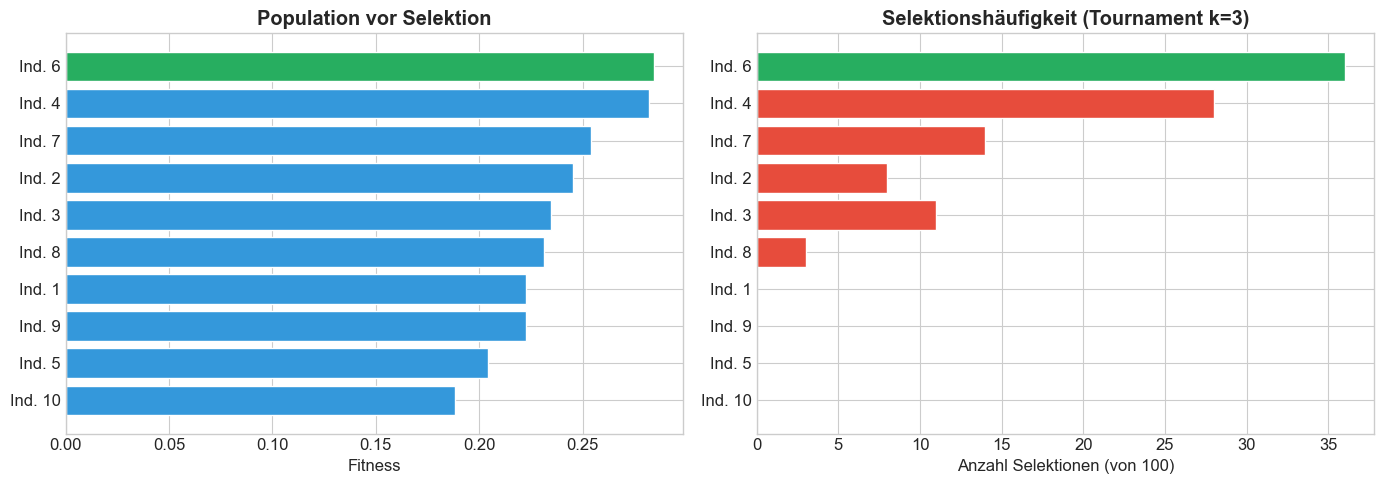


→ Individuen mit höherer Fitness werden häufiger selektiert!
→ Aber auch schlechtere Individuen haben eine Chance (Diversität bleibt erhalten)


In [58]:
# Visualisierung: Selektion in Aktion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sortierte Fitnesswerte für bessere Darstellung
sorted_indices = np.argsort(demo_fitnesses)[::-1]
sorted_fitnesses = [demo_fitnesses[i] for i in sorted_indices]

# Links: Fitness vor Selektion
colors = ['#27AE60' if f == max(demo_fitnesses) else '#3498DB' for f in sorted_fitnesses]
axes[0].barh(range(demo_pop_size), sorted_fitnesses, color=colors, edgecolor='white')
axes[0].set_yticks(range(demo_pop_size))
axes[0].set_yticklabels([f"Ind. {sorted_indices[i]+1}" for i in range(demo_pop_size)])
axes[0].set_xlabel('Fitness')
axes[0].set_title('Population vor Selektion', fontweight='bold')
axes[0].invert_yaxis()

# Rechts: Häufigkeit nach mehreren Turnieren
n_selections = 100
selection_counts = np.zeros(demo_pop_size)
for _ in range(n_selections):
    winner = tournament_selection(demo_population, demo_fitnesses, tournament_size=3)
    # Finde den Index des Gewinners
    for i, route in enumerate(demo_population):
        if np.array_equal(route, winner):
            selection_counts[i] += 1
            break

# Nach sortierter Reihenfolge anzeigen
sorted_counts = [selection_counts[i] for i in sorted_indices]
colors2 = ['#27AE60' if c == max(sorted_counts) else '#E74C3C' for c in sorted_counts]
axes[1].barh(range(demo_pop_size), sorted_counts, color=colors2, edgecolor='white')
axes[1].set_yticks(range(demo_pop_size))
axes[1].set_yticklabels([f"Ind. {sorted_indices[i]+1}" for i in range(demo_pop_size)])
axes[1].set_xlabel(f'Anzahl Selektionen (von {n_selections})')
axes[1].set_title('Selektionshäufigkeit (Tournament k=3)', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
save_figure(fig, '04_selektion_vergleich.png')
plt.show()

print("\n→ Individuen mit höherer Fitness werden häufiger selektiert!")
print("→ Aber auch schlechtere Individuen haben eine Chance (Diversität bleibt erhalten)")


---

## 5. Variationsoperatoren für Permutationen

Variationsoperatoren erzeugen neue Individuen aus bestehenden. Bei Permutationen müssen wir aufpassen, dass die Gültigkeit erhalten bleibt (jede Stadt genau einmal).

### 5.1 Mutation: Invertierende Mutation (Inversion Mutation)

Bei der **invertierenden Mutation** wird eine zufällige Subsequenz ausgewählt und **umgekehrt**:

```
Vorher:  [0, 1, 2, 3, 4, 5]
              ↓     ↓
Nachher: [0, 1, 4, 3, 2, 5]  (Positionen 2-4 invertiert)
```

**Vorteil:** Diese Mutation bewirkt "kleinere" Veränderungen als z.B. das einfache Vertauschen zweier Städte, da benachbarte Städte oft benachbart bleiben.

### 5.2 Rekombination: Order Crossover (OX)

Beim **Order Crossover** wird ein Segment von Elternteil 1 übernommen und der Rest mit den fehlenden Städten aus Elternteil 2 (in deren Reihenfolge) aufgefüllt:

```
Elternteil 1: [1, 2, |3, 4, 5|, 6, 7]  → Segment [3,4,5] übernehmen
Elternteil 2: [5, 4, 6, 7, 2, 1, 3]   → Reihenfolge: 6, 7, 2, 1

Kind:         [6, 7, |3, 4, 5|, 2, 1]
```


In [59]:
def inversion_mutation(route, mutation_rate=0.1):
    """
    Führt eine invertierende Mutation durch.
    
    Parameter:
        route: Route als numpy array
        mutation_rate: Wahrscheinlichkeit, dass Mutation stattfindet
    
    Rückgabe:
        Mutierte Route (oder Kopie der ursprünglichen)
    """
    mutated = route.copy()
    
    if np.random.random() < mutation_rate:
        # Zwei zufällige Positionen wählen
        n = len(route)
        i, j = sorted(np.random.choice(n, 2, replace=False))
        
        # Subsequenz umkehren
        mutated[i:j+1] = mutated[i:j+1][::-1]
    
    return mutated


def order_crossover(parent1, parent2):
    """
    Führt Order Crossover (OX) durch - korrekte theoretische Implementierung.
    
    Parameter:
        parent1, parent2: Eltern-Routen als numpy arrays
    
    Rückgabe:
        Kind-Route
    
    Algorithmus:
    1. Wähle zwei Cut-Points (start, end) in parent1
    2. Kopiere das Segment von parent1 ins Kind
    3. Fülle die fehlenden Städte aus parent2 zyklisch nach dem zweiten Cut-Point ein
    """
    n = len(parent1)
    child = np.full(n, -1)
    
    # Zufälliges Segment von parent1 auswählen
    start, end = sorted(np.random.choice(n, 2, replace=False))
    
    # Segment von parent1 in child kopieren
    child[start:end+1] = parent1[start:end+1]
    
    # Fehlende Städte aus parent2 sammeln (in der Reihenfolge, wie sie in parent2 erscheinen)
    segment_values = set(child[start:end+1])
    remaining = [x for x in parent2 if x not in segment_values]
    
    # Zyklisch nach dem zweiten Cut-Point (end) einfügen
    # Beginne bei Position (end + 1) % n und fülle zyklisch auf
    remaining_idx = 0
    pos = (end + 1) % n  # Startposition nach dem Segment
    
    # Fülle alle leeren Positionen zyklisch auf
    while remaining_idx < len(remaining):
        if child[pos] == -1:  # Leere Position gefunden
            child[pos] = remaining[remaining_idx]
            remaining_idx += 1
        pos = (pos + 1) % n  # Zyklisch weiter
    
    return child


# Demonstration der Mutation
print("=" * 60)
print("DEMONSTRATION: Invertierende Mutation")
print("=" * 60)

# Zufällige Route erstellen (nutzt den globalen RNG-State)
original_route = create_random_route(len(city_names))
print(f"\nOriginal-Route: {list(original_route)}")
print(f"               ({' → '.join([city_names[i] for i in original_route])})")

# Mutation durchführen (erzwungen für Demo)
mutated_route = original_route.copy()
# Zufällige Positionen für Inversion wählen
i, j = sorted(np.random.choice(len(original_route), 2, replace=False))
mutated_route[i:j+1] = mutated_route[i:j+1][::-1]

print(f"\nMutierte Route: {list(mutated_route)}  (Positionen {i}-{j} invertiert)")
print(f"               ({' → '.join([city_names[idx] for idx in mutated_route])})")


DEMONSTRATION: Invertierende Mutation

Original-Route: [0, 6, 7, 5, 2, 4, 1, 3]
               (Köln → Düren → Euskirchen → Leverkusen → Düsseldorf → Wuppertal → Bonn → Aachen)

Mutierte Route: [0, 6, 7, 1, 4, 2, 5, 3]  (Positionen 3-6 invertiert)
               (Köln → Düren → Euskirchen → Bonn → Wuppertal → Düsseldorf → Leverkusen → Aachen)


  → Grafik gespeichert: files/05b_mutation_chromosom.png


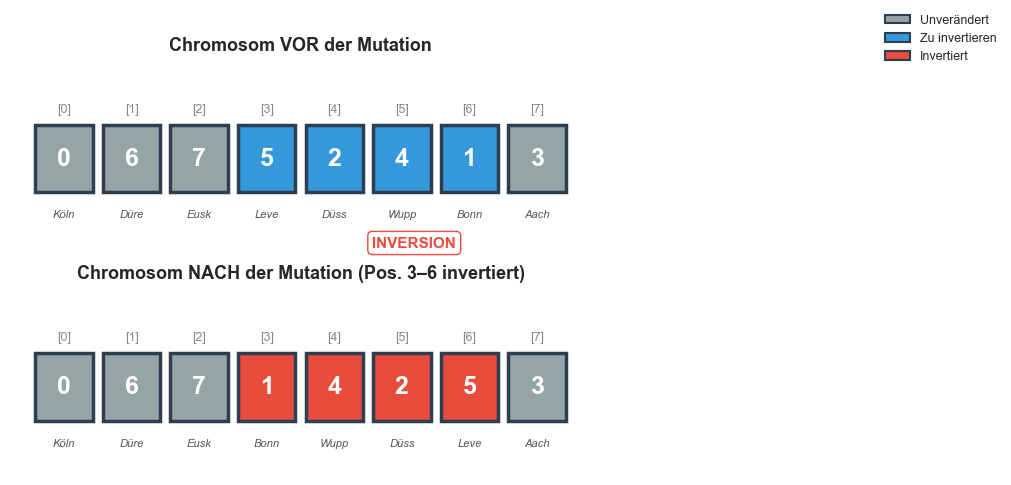

In [60]:
def plot_chromosome_mutation(original, mutated, inversion_start, inversion_end, city_names, save_path=None):
    """
    Erstellt eine Chromosom-Style Visualisierung der Inversion-Mutation.
    
    Zeigt das Original-Chromosom und das mutierte Chromosom mit 
    hervorgehobener invertierter Subsequenz im Box-Stil.
    """
    n = len(original)
    fig, axes = plt.subplots(2, 1, figsize=(14, 5))
    
    # Farben definieren
    color_normal = '#3498DB'      # Blau für zu invertierende Gene
    color_inverted = '#E74C3C'    # Rot für invertierte Gene
    color_unchanged = '#95A5A6'   # Grau für unveränderte Gene
    box_edge = '#2C3E50'          # Dunkler Rand
    
    def draw_chromosome(ax, chromosome, title, highlight_range=None, is_inverted=False):
        """Zeichnet ein einzelnes Chromosom als Boxen-Reihe."""
        ax.set_xlim(-0.8, n - 0.2)
        ax.set_ylim(-0.8, 1.8)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(title, fontsize=13, fontweight='bold', pad=15)
        
        box_width = 0.85
        box_height = 1.0
        
        for idx, gene in enumerate(chromosome):
            # Farbe bestimmen
            if highlight_range and highlight_range[0] <= idx <= highlight_range[1]:
                color = color_inverted if is_inverted else color_normal
            else:
                color = color_unchanged
            
            # Box zeichnen
            rect = plt.Rectangle((idx - box_width/2, 0), box_width, box_height,
                                  facecolor=color, edgecolor=box_edge, 
                                  linewidth=2.5, zorder=2)
            ax.add_patch(rect)
            
            # Gen-Wert (Stadt-Index) in der Box
            ax.text(idx, box_height/2, str(gene), ha='center', va='center',
                   fontsize=18, fontweight='bold', color='white', zorder=3)
            
            # Stadt-Abkürzung unter der Box
            ax.text(idx, -0.25, city_names[gene][:4], ha='center', va='top',
                   fontsize=8, color='#555555', style='italic')
        
        # Position-Index über den Boxen
        for idx in range(n):
            ax.text(idx, box_height + 0.15, f'[{idx}]', ha='center', va='bottom',
                   fontsize=9, color='#888888')
    
    # Original-Chromosom (oben)
    draw_chromosome(axes[0], original, 
                   'Chromosom VOR der Mutation',
                   highlight_range=(inversion_start, inversion_end), 
                   is_inverted=False)
    
    # Mutiertes Chromosom (unten)
    draw_chromosome(axes[1], mutated, 
                   f'Chromosom NACH der Mutation (Pos. {inversion_start}–{inversion_end} invertiert)',
                   highlight_range=(inversion_start, inversion_end), 
                   is_inverted=True)
    
    # Pfeile für die Inversion zwischen den Plots
    for pos in range(inversion_start, inversion_end + 1):
        # Position berechnen (normalisiert)
        x_norm = (pos + 0.42) / (n + 0.6) * 0.78 + 0.11
        ax.annotate('', xy=(x_norm, 0.42), xytext=(x_norm, 0.58),
                    xycoords='figure fraction',
                    arrowprops=dict(arrowstyle='->', color=color_inverted, lw=2))
    
    # Inversion-Label
    mid_pos = (inversion_start + inversion_end) / 2
    x_mid = (mid_pos + 0.42) / (n + 0.6) * 0.78 + 0.11
    fig.text(x_mid, 0.50, 'INVERSION', ha='center', va='center', 
             fontsize=11, fontweight='bold', color=color_inverted,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=color_inverted))
    
    # Legende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=color_unchanged, edgecolor=box_edge, linewidth=1.5, label='Unverändert'),
        Patch(facecolor=color_normal, edgecolor=box_edge, linewidth=1.5, label='Zu invertieren'),
        Patch(facecolor=color_inverted, edgecolor=box_edge, linewidth=1.5, label='Invertiert'),
    ]
    fig.legend(handles=legend_elements, loc='upper right', 
              bbox_to_anchor=(0.98, 0.98), fontsize=9, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    
    if save_path:
        save_figure(fig, save_path)
    
    # plt.show()
    # return fig

# Chromosom-Visualisierung der Mutation erstellen
# Verwende die bereits generierten original_route und mutated_route sowie i, j
plot_chromosome_mutation(original_route, mutated_route, i, j, city_names, 
                        save_path='05b_mutation_chromosom.png')

  → Grafik gespeichert: files/05_mutation_vorher_nachher.png


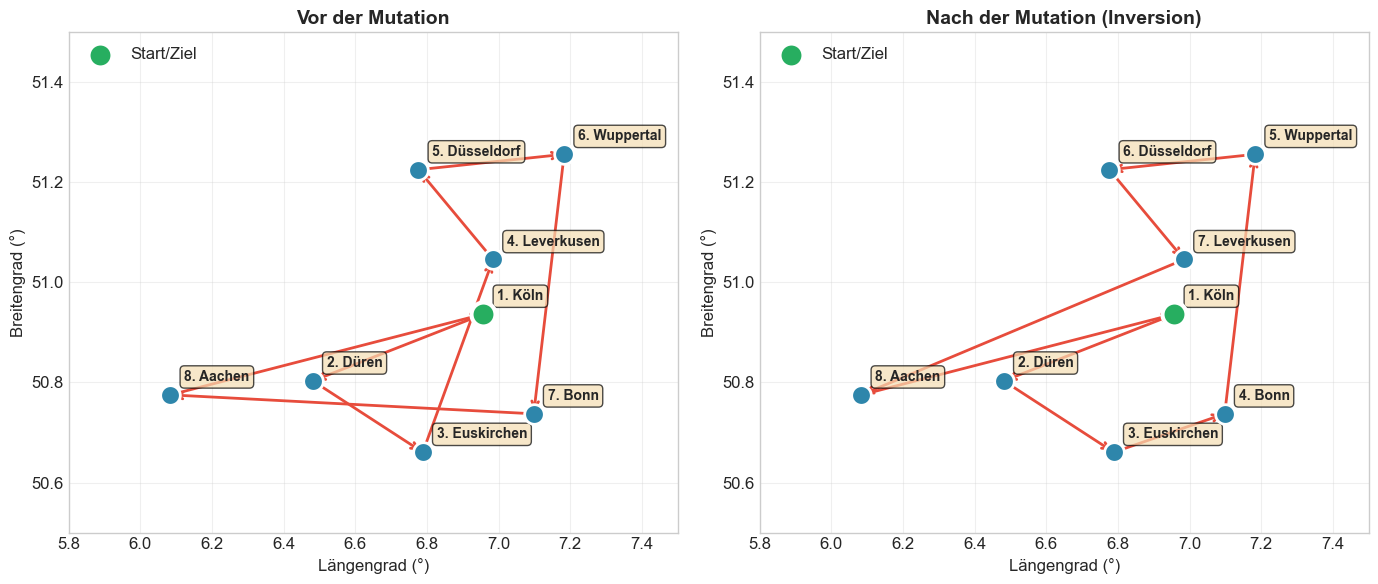


Distanz vorher:  4.3780
Distanz nachher: 4.1902
Änderung:        -0.1878 (besser)


In [61]:
# Visualisierung: Vorher/Nachher der Mutation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_route(original_route, city_coords, city_names, 
           title="Vor der Mutation", ax=axes[0])
plot_route(mutated_route, city_coords, city_names, 
           title="Nach der Mutation (Inversion)", ax=axes[1])

plt.tight_layout()
save_figure(fig, '05_mutation_vorher_nachher.png')
plt.show()

# Distanzvergleich
dist_before = calculate_route_distance(original_route, dist_matrix)
dist_after = calculate_route_distance(mutated_route, dist_matrix)
print(f"\nDistanz vorher:  {dist_before:.4f}")
print(f"Distanz nachher: {dist_after:.4f}")
print(f"Änderung:        {dist_after - dist_before:+.4f} ({'schlechter' if dist_after > dist_before else 'besser'})")


In [62]:
# Demonstration des Order Crossover
print("=" * 60)
print("DEMONSTRATION: Order Crossover (OX)")
print("=" * 60)

# Eltern zufällig generieren (nutzt den globalen RNG-State)
parent1 = create_random_route(len(city_names))
parent2 = create_random_route(len(city_names))

print(f"\nElternteil 1: {list(parent1)}")
print(f"             ({' → '.join([city_names[i] for i in parent1])})")
print(f"\nElternteil 2: {list(parent2)}")
print(f"             ({' → '.join([city_names[i] for i in parent2])})")

# Crossover durchführen
child = order_crossover(parent1, parent2)

print(f"\nKind:         {list(child)}")
print(f"             ({' → '.join([city_names[i] for i in child])})")


DEMONSTRATION: Order Crossover (OX)

Elternteil 1: [5, 6, 0, 7, 3, 2, 4, 1]
             (Leverkusen → Düren → Köln → Euskirchen → Aachen → Düsseldorf → Wuppertal → Bonn)

Elternteil 2: [7, 5, 4, 1, 0, 6, 3, 2]
             (Euskirchen → Leverkusen → Wuppertal → Bonn → Köln → Düren → Aachen → Düsseldorf)

Kind:         [7, 5, 0, 6, 3, 2, 4, 1]
             (Euskirchen → Leverkusen → Köln → Düren → Aachen → Düsseldorf → Wuppertal → Bonn)


  → Grafik gespeichert: files/06b_crossover_chromosom.png


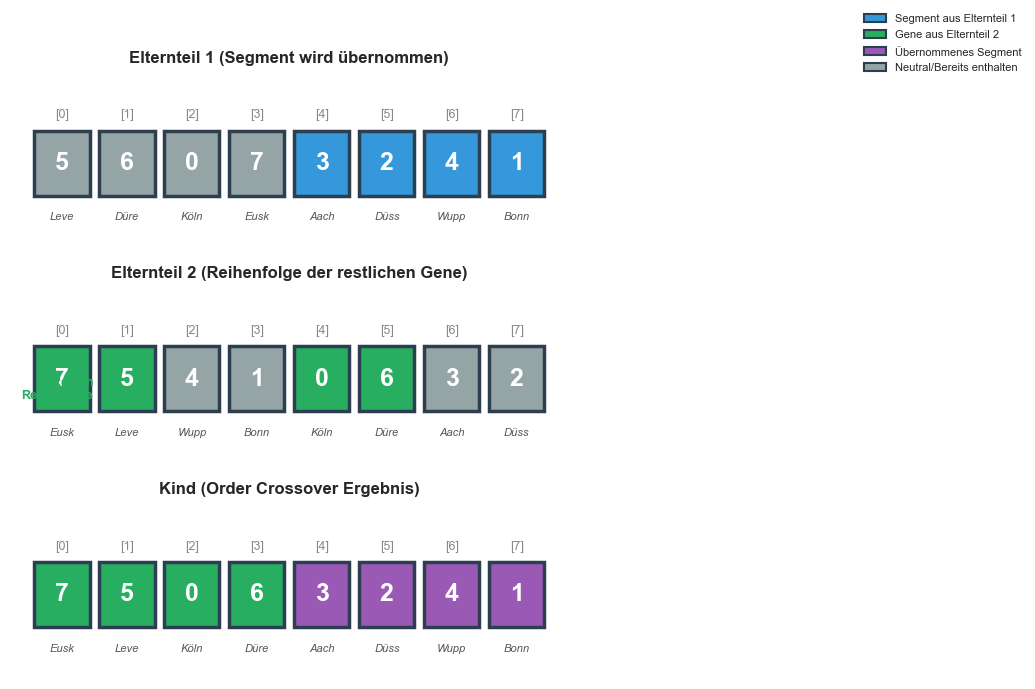

In [63]:
def plot_chromosome_crossover(parent1, parent2, child, city_names, save_path=None):
    """
    Erstellt eine Chromosom-Style Visualisierung des Order Crossover (OX).
    
    Zeigt beide Eltern-Chromosomen und das Kind mit hervorgehobenen
    Segmenten im klassischen Box-Stil.
    """
    n = len(parent1)
    fig, axes = plt.subplots(3, 1, figsize=(14, 7))
    
    # Farben definieren
    color_parent1 = '#3498DB'     # Blau für Elternteil 1 Segment
    color_parent2 = '#27AE60'     # Grün für Elternteil 2 Beitrag
    color_neutral = '#95A5A6'     # Grau für neutrale Gene
    color_child_seg = '#9B59B6'   # Lila für übernommenes Segment im Kind
    box_edge = '#2C3E50'          # Dunkler Rand
    
    # Crossover-Punkte identifizieren (suche das Segment in parent1, das im Kind erscheint)
    # Finde übereinstimmende zusammenhängende Sequenz
    segment_start, segment_end = None, None
    for start in range(n):
        for end in range(start + 1, n):
            segment = list(parent1[start:end+1])
            # Prüfe ob dieses Segment zusammenhängend im Kind vorkommt
            for child_start in range(n):
                child_end = child_start + len(segment)
                if child_end <= n:
                    if list(child[child_start:child_end]) == segment:
                        if segment_end is None or (end - start) > (segment_end - segment_start):
                            segment_start, segment_end = start, end
                            child_seg_start = child_start
    
    # Fallback wenn kein Segment gefunden
    if segment_start is None:
        segment_start, segment_end = 1, 3
        child_seg_start = 1
    
    def draw_chromosome(ax, chromosome, title, highlight_info=None, role='neutral'):
        """Zeichnet ein einzelnes Chromosom als Boxen-Reihe."""
        ax.set_xlim(-0.8, n - 0.2)
        ax.set_ylim(-0.8, 1.8)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(title, fontsize=12, fontweight='bold', pad=12)
        
        box_width = 0.85
        box_height = 1.0
        
        for idx, gene in enumerate(chromosome):
            # Farbe basierend auf Rolle und Position
            if role == 'parent1':
                if highlight_info and highlight_info[0] <= idx <= highlight_info[1]:
                    color = color_parent1
                else:
                    color = color_neutral
            elif role == 'parent2':
                # Gene, die im Kind aus Parent2 kommen
                segment_values = set(parent1[segment_start:segment_end+1])
                if gene not in segment_values:
                    color = color_parent2
                else:
                    color = color_neutral
            elif role == 'child':
                if highlight_info and highlight_info[0] <= idx <= highlight_info[1]:
                    color = color_child_seg
                else:
                    # Prüfe ob Gen aus Parent2 stammt
                    segment_values = set(parent1[segment_start:segment_end+1])
                    if gene not in segment_values:
                        color = color_parent2
                    else:
                        color = color_neutral
            else:
                color = color_neutral
            
            # Box zeichnen
            rect = plt.Rectangle((idx - box_width/2, 0), box_width, box_height,
                                  facecolor=color, edgecolor=box_edge, 
                                  linewidth=2.5, zorder=2)
            ax.add_patch(rect)
            
            # Gen-Wert (Stadt-Index) in der Box
            ax.text(idx, box_height/2, str(gene), ha='center', va='center',
                   fontsize=18, fontweight='bold', color='white', zorder=3)
            
            # Stadt-Abkürzung unter der Box
            ax.text(idx, -0.25, city_names[gene][:4], ha='center', va='top',
                   fontsize=8, color='#555555', style='italic')
        
        # Position-Index über den Boxen
        for idx in range(n):
            ax.text(idx, box_height + 0.15, f'[{idx}]', ha='center', va='bottom',
                   fontsize=9, color='#888888')
    
    # Elternteil 1 (oben)
    draw_chromosome(axes[0], parent1, 
                   'Elternteil 1 (Segment wird übernommen)',
                   highlight_info=(segment_start, segment_end), 
                   role='parent1')
    
    # Elternteil 2 (Mitte)
    draw_chromosome(axes[1], parent2, 
                   'Elternteil 2 (Reihenfolge der restlichen Gene)',
                   role='parent2')
    
    # Kind (unten)
    draw_chromosome(axes[2], child, 
                   'Kind (Order Crossover Ergebnis)',
                   highlight_info=(child_seg_start, child_seg_start + (segment_end - segment_start)),
                   role='child')
    
    # Verbindungspfeile und Labels
    # Pfeil von Parent1 zum Kind (Segment)
    ax.annotate('', xy=(0.5, 0.38), xytext=(0.5, 0.62),
                xycoords='figure fraction',
                arrowprops=dict(arrowstyle='->', color=color_parent1, lw=2.5, 
                               connectionstyle='arc3,rad=0.2'))
    
    # Pfeil von Parent2 zum Kind (Rest)
    ax.annotate('', xy=(0.42, 0.38), xytext=(0.42, 0.50),
                xycoords='figure fraction',
                arrowprops=dict(arrowstyle='->', color=color_parent2, lw=2.5,
                               connectionstyle='arc3,rad=-0.2'))
    fig.text(0.32, 0.44, 'Rest in\nReihenfolge', ha='right', va='center', 
             fontsize=9, fontweight='bold', color=color_parent2)
    
    # Legende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=color_parent1, edgecolor=box_edge, linewidth=1.5, label='Segment aus Elternteil 1'),
        Patch(facecolor=color_parent2, edgecolor=box_edge, linewidth=1.5, label='Gene aus Elternteil 2'),
        Patch(facecolor=color_child_seg, edgecolor=box_edge, linewidth=1.5, label='Übernommenes Segment'),
        Patch(facecolor=color_neutral, edgecolor=box_edge, linewidth=1.5, label='Neutral/Bereits enthalten'),
    ]
    fig.legend(handles=legend_elements, loc='upper right', 
              bbox_to_anchor=(0.99, 0.99), fontsize=8, framealpha=0.9)
    
    plt.tight_layout(rect=[0, 0, 0.92, 0.95])
    
    if save_path:
        save_figure(fig, save_path)
    
    # plt.show()
    # return fig

# Chromosom-Visualisierung des Crossover erstellen
# Verwende die bereits generierten parent1, parent2 und child
plot_chromosome_crossover(parent1, parent2, child, city_names,
                         save_path='06b_crossover_chromosom.png')

  → Grafik gespeichert: files/06_crossover_eltern_kind.png


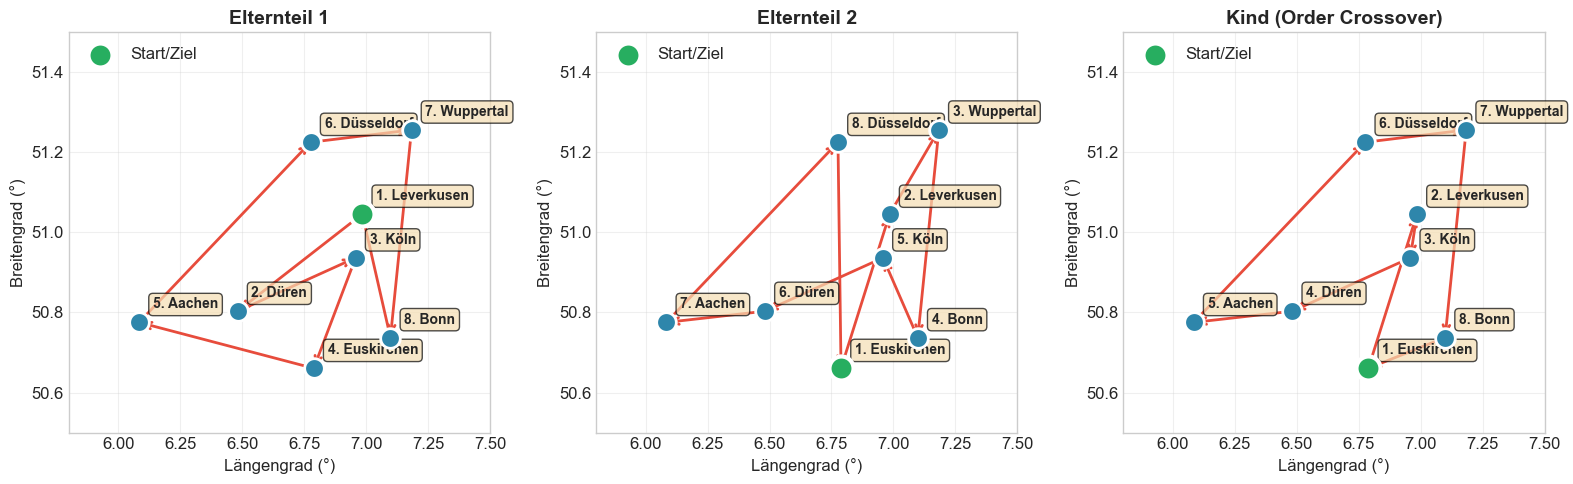


Fitness Elternteil 1: 0.2393 (Distanz: 4.1794)
Fitness Elternteil 2: 0.2649 (Distanz: 3.7751)
Fitness Kind:         0.2844 (Distanz: 3.5168)


In [64]:
# Visualisierung: Crossover
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

plot_route(parent1, city_coords, city_names, 
           title="Elternteil 1", ax=axes[0])
plot_route(parent2, city_coords, city_names, 
           title="Elternteil 2", ax=axes[1])
plot_route(child, city_coords, city_names, 
           title="Kind (Order Crossover)", ax=axes[2])

plt.tight_layout()
save_figure(fig, '06_crossover_eltern_kind.png')
plt.show()

# Fitness-Vergleich
fit_p1 = calculate_fitness(parent1, dist_matrix)
fit_p2 = calculate_fitness(parent2, dist_matrix)
fit_child = calculate_fitness(child, dist_matrix)

print(f"\nFitness Elternteil 1: {fit_p1:.4f} (Distanz: {1/fit_p1:.4f})")
print(f"Fitness Elternteil 2: {fit_p2:.4f} (Distanz: {1/fit_p2:.4f})")
print(f"Fitness Kind:         {fit_child:.4f} (Distanz: {1/fit_child:.4f})")


---

## 6. Der Evolutionäre Zyklus (Main Loop)

### Der generische Ablauf eines EA

Ein evolutionärer Algorithmus folgt diesem Grundmuster:

1. **Initialisierung**: Erstelle zufällige Startpopulation
2. **Evaluierung**: Berechne Fitness aller Individuen
3. **Selektion**: Wähle Eltern basierend auf Fitness
4. **Rekombination**: Erzeuge Kinder durch Crossover
5. **Mutation**: Verändere Kinder zufällig
6. **Ersetzung**: Bilde neue Generation (mit Elitismus)
7. **Abbruch?**: Wiederhole ab Schritt 2 oder stoppe

### Analogie: Der digitale Logistikplaner

> *Stell dir das TSP-Projekt wie einen digitalen Logistikplaner vor. Anstatt jede mögliche Route auszuprobieren (was Jahre dauern würde), lassen wir eine Population von "Versuchsrouten" gegeneinander antreten. Die fittesten Routen dürfen sich "paaren" (Crossover), während kleine "Irrtümer" (Mutation) sicherstellen, dass wir auch neue Abkürzungen entdecken, an die wir vorher nicht gedacht haben.*


In [65]:
def run_evolution(coords, dist_matrix, 
                  pop_size=50, 
                  n_generations=N_GENERATIONS,
                  mutation_rate=0.1,
                  tournament_size=3,
                  n_elites=2,
                  crossover_rate=0.8,
                  verbose=True,
                  track_history=True):
    """
    Führt den vollständigen evolutionären Algorithmus durch.
    
    Parameter:
        coords: Koordinaten der Städte
        dist_matrix: Distanzmatrix
        pop_size: Populationsgröße
        n_generations: Anzahl der Generationen
        mutation_rate: Mutationswahrscheinlichkeit
        tournament_size: Größe des Turniers für Selektion
        n_elites: Anzahl der Eliten
        crossover_rate: Wahrscheinlichkeit für Crossover
        verbose: Fortschrittsausgabe
        track_history: Geschichte für Animation speichern
    
    Rückgabe:
        Dictionary mit Ergebnissen und Statistiken
    """
    n_cities = len(coords)
    
    # 1. INITIALISIERUNG
    population = [create_random_route(n_cities) for _ in range(pop_size)]
    
    # Tracking-Variablen
    best_distances = []
    avg_distances = []
    best_route_history = []
    
    # Initiale Evaluierung
    fitnesses = [calculate_fitness(route, dist_matrix) for route in population]
    
    best_idx = np.argmax(fitnesses)
    best_route = population[best_idx].copy()
    best_distance = calculate_route_distance(best_route, dist_matrix)
    
    if track_history:
        best_route_history.append(best_route.copy())
    
    # EVOLUTION LOOP
    for gen in range(n_generations):
        # 2. EVALUIERUNG (bereits oben gemacht)
        
        # Statistiken
        distances = [calculate_route_distance(r, dist_matrix) for r in population]
        best_distances.append(min(distances))
        avg_distances.append(np.mean(distances))
        
        # 3. SELEKTION + VARIATION
        new_population = []
        
        # Elitismus: Beste Individuen übernehmen
        elites = select_elites(population, fitnesses, n_elites)
        new_population.extend(elites)
        
        # Rest der Population durch Selektion und Variation
        while len(new_population) < pop_size:
            # Eltern selektieren
            parent1 = tournament_selection(population, fitnesses, tournament_size)
            parent2 = tournament_selection(population, fitnesses, tournament_size)
            
            # 4. REKOMBINATION
            if np.random.random() < crossover_rate:
                child = order_crossover(parent1, parent2)
            else:
                child = parent1.copy()
            
            # 5. MUTATION
            child = inversion_mutation(child, mutation_rate)
            
            new_population.append(child)
        
        # 6. ERSETZUNG
        population = new_population[:pop_size]
        fitnesses = [calculate_fitness(route, dist_matrix) for route in population]
        
        # Bestes Individuum aktualisieren
        gen_best_idx = np.argmax(fitnesses)
        gen_best_distance = calculate_route_distance(population[gen_best_idx], dist_matrix)
        
        if gen_best_distance < best_distance:
            best_distance = gen_best_distance
            best_route = population[gen_best_idx].copy()
        
        if track_history and gen % 5 == 0:  # Alle 5 Generationen speichern
            best_route_history.append(best_route.copy())
        
        # Fortschrittsausgabe
        if verbose and (gen + 1) % 20 == 0:
            print(f"Generation {gen+1:3d}: Beste Distanz = {best_distance:.4f}, "
                  f"Durchschnitt = {avg_distances[-1]:.4f}")
    
    return {
        'best_route': best_route,
        'best_distance': best_distance,
        'best_distances': best_distances,
        'avg_distances': avg_distances,
        'route_history': best_route_history,
        'final_population': population
    }


In [66]:
# EA ausführen
print("=" * 60)
print("EVOLUTIONÄRER ALGORITHMUS - DEMO RUN")
print("=" * 60)
print(f"\nParameter:")
print(f"  Populationsgröße:  50")
print(f"  Generationen:      {N_GENERATIONS}")
print(f"  Mutationsrate:     0.1")
print(f"  Turniergröße:      3")
print(f"  Eliten:            2")
print(f"\nStart der Evolution...")
print("-" * 60)

# Seed für diesen Lauf setzen (verwendet GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
results = run_evolution(
    city_coords, 
    dist_matrix,
    pop_size=50,
    n_generations=N_GENERATIONS,
    mutation_rate=0.1,
    tournament_size=3,
    n_elites=2
)

print("-" * 60)
print(f"\nErgebnis:")
print(f"  Beste Route:    {list(results['best_route'])}")
print(f"  Beste Distanz:  {results['best_distance']:.4f}")
print(f"  Route: {' → '.join([city_names[i] for i in results['best_route']])} → {city_names[results['best_route'][0]]}")


EVOLUTIONÄRER ALGORITHMUS - DEMO RUN

Parameter:
  Populationsgröße:  50
  Generationen:      20
  Mutationsrate:     0.1
  Turniergröße:      3
  Eliten:            2

Start der Evolution...
------------------------------------------------------------
Generation  20: Beste Distanz = 2.9357, Durchschnitt = 3.2239
------------------------------------------------------------

Ergebnis:
  Beste Route:    [0, 5, 4, 2, 3, 6, 7, 1]
  Beste Distanz:  2.9357
  Route: Köln → Leverkusen → Wuppertal → Düsseldorf → Aachen → Düren → Euskirchen → Bonn → Köln


  → Grafik gespeichert: files/07_konvergenz_beste_route.png


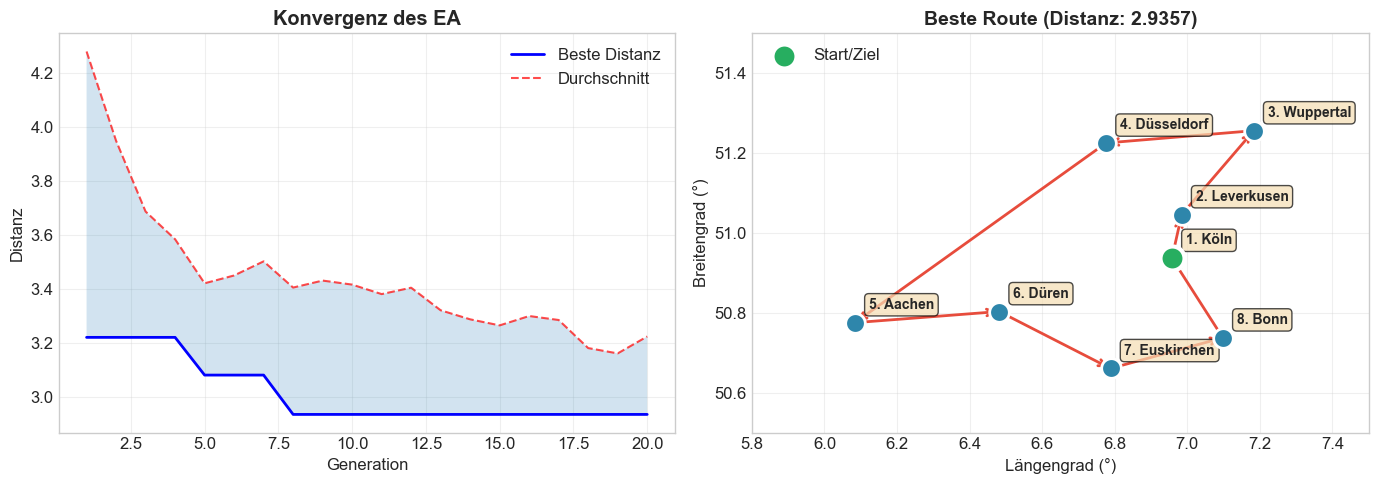

In [67]:
# Konvergenzgrafik
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Links: Distanz über Generationen
generations = range(1, len(results['best_distances']) + 1)
axes[0].plot(generations, results['best_distances'], 'b-', linewidth=2, label='Beste Distanz')
axes[0].plot(generations, results['avg_distances'], 'r--', linewidth=1.5, alpha=0.7, label='Durchschnitt')
axes[0].fill_between(generations, results['best_distances'], results['avg_distances'], alpha=0.2)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Distanz')
axes[0].set_title('Konvergenz des EA', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rechts: Beste gefundene Route
plot_route(results['best_route'], city_coords, city_names, 
           title=f"Beste Route (Distanz: {results['best_distance']:.4f})", ax=axes[1])

plt.tight_layout()
save_figure(fig, '07_konvergenz_beste_route.png')
plt.show()


### Animation: Route-Entwicklung über die Generationen

Die folgende Animation zeigt, wie sich die beste Route über die Evolution hinweg verbessert:


In [68]:
def create_evolution_animation(route_history, coords, names, dist_matrix):
    """
    Erstellt eine Animation der Route-Entwicklung.
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def animate(frame):
        ax.clear()
        route = route_history[frame]
        route_coords = coords[route]
        
        # Städte plotten
        ax.scatter(coords[:, 0], coords[:, 1], 
                   s=200, c='#2E86AB', edgecolors='white', linewidths=2, zorder=5)
        
        # Route als Linien
        for i in range(len(route)):
            start = route_coords[i]
            end = route_coords[(i + 1) % len(route)]
            ax.annotate('', xy=end, xytext=start,
                       arrowprops=dict(arrowstyle='->', color='#E74C3C', lw=2))
        
        # Startpunkt
        ax.scatter(route_coords[0, 0], route_coords[0, 1], 
                   s=300, c='#27AE60', edgecolors='white', linewidths=3, zorder=6)
        
        # Labels
        for i, name in enumerate(names):
            ax.annotate(name, (coords[i, 0], coords[i, 1]),
                       xytext=(10, 10), textcoords='offset points',
                       fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.7))
        
        distance = calculate_route_distance(route, dist_matrix)
        gen = frame * 5  # Wir speichern alle 5 Generationen
        ax.set_title(f'Generation {gen} | Distanz: {distance:.4f}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Längengrad (°)')
        ax.set_ylabel('Breitengrad (°)')
        ax.set_xlim(5.8, 7.5)
        ax.set_ylim(50.5, 51.5)
        ax.grid(True, alpha=0.3)
    
    anim = FuncAnimation(fig, animate, frames=len(route_history), 
                         interval=500, repeat=True)
    plt.close()
    return anim

# Animation erstellen
anim = create_evolution_animation(results['route_history'], city_coords, city_names, dist_matrix)
HTML(anim.to_jshtml())


---

## 7. Statistische Auswertung

### Warum statistische Absicherung?

Evolutionäre Algorithmen sind **stochastisch** – jeder Lauf kann unterschiedliche Ergebnisse liefern. Um valide Aussagen zu treffen, müssen wir:

1. **Mehrere Testläufe** durchführen (mindestens 30)
2. **Mittelwert und Streuung** analysieren
3. **Parameter vergleichen** (z.B. verschiedene Mutationsraten)

### Experimentdesign

Wir untersuchen:
- **Mutationsraten**: 0.01, 0.05, 0.1, 0.2
- **Populationsgrößen**: 20, 50, 100
- **30 Läufe** pro Konfiguration


In [69]:
def run_experiments(coords, dist_matrix, configs, n_runs=30, n_generations=N_GENERATIONS):
    """
    Führt mehrere Experimente mit verschiedenen Konfigurationen durch.
    
    Parameter:
        coords: Stadtkoordinaten
        dist_matrix: Distanzmatrix
        configs: Liste von Konfigurationsdictionaries
        n_runs: Anzahl Läufe pro Konfiguration
        n_generations: Anzahl Generationen pro Lauf
    
    Rückgabe:
        DataFrame mit allen Ergebnissen
    """
    results = []
    
    for config in configs:
        config_name = config.get('name', str(config))
        print(f"\nKonfiguration: {config_name}")
        
        for run in range(n_runs):
            result = run_evolution(
                coords, dist_matrix,
                pop_size=config.get('pop_size', 50),
                n_generations=n_generations,
                mutation_rate=config.get('mutation_rate', 0.1),
                tournament_size=config.get('tournament_size', 3),
                n_elites=config.get('n_elites', 2),
                verbose=False,
                track_history=False
            )
            
            results.append({
                'config': config_name,
                'run': run + 1,
                'best_distance': result['best_distance'],
                'mutation_rate': config.get('mutation_rate', 0.1),
                'pop_size': config.get('pop_size', 50)
            })
            
            if (run + 1) % 10 == 0:
                print(f"  Lauf {run + 1}/{n_runs} abgeschlossen")
    
    return pd.DataFrame(results)


# Experimente definieren und ausführen
print("=" * 60)
print("STATISTISCHE AUSWERTUNG - 30 Läufe pro Konfiguration")
print("=" * 60)

# Experiment 1: Verschiedene Mutationsraten
mutation_configs = [
    {'name': 'MR=0.01', 'mutation_rate': 0.01, 'pop_size': 50},
    {'name': 'MR=0.05', 'mutation_rate': 0.05, 'pop_size': 50},
    {'name': 'MR=0.10', 'mutation_rate': 0.10, 'pop_size': 50},
    {'name': 'MR=0.20', 'mutation_rate': 0.20, 'pop_size': 50},
]

print("\n--- Experiment 1: Mutationsraten ---")
mutation_results = run_experiments(city_coords, dist_matrix, mutation_configs, n_runs=30, n_generations=N_GENERATIONS)


STATISTISCHE AUSWERTUNG - 30 Läufe pro Konfiguration

--- Experiment 1: Mutationsraten ---

Konfiguration: MR=0.01
  Lauf 10/30 abgeschlossen
  Lauf 20/30 abgeschlossen
  Lauf 30/30 abgeschlossen

Konfiguration: MR=0.05
  Lauf 10/30 abgeschlossen
  Lauf 20/30 abgeschlossen
  Lauf 30/30 abgeschlossen

Konfiguration: MR=0.10
  Lauf 10/30 abgeschlossen
  Lauf 20/30 abgeschlossen
  Lauf 30/30 abgeschlossen

Konfiguration: MR=0.20
  Lauf 10/30 abgeschlossen
  Lauf 20/30 abgeschlossen
  Lauf 30/30 abgeschlossen


In [70]:
# Experiment 2: Verschiedene Populationsgrößen
popsize_configs = [
    {'name': 'Pop=20', 'mutation_rate': 0.1, 'pop_size': 20},
    {'name': 'Pop=50', 'mutation_rate': 0.1, 'pop_size': 50},
    {'name': 'Pop=100', 'mutation_rate': 0.1, 'pop_size': 100},
]

print("\n--- Experiment 2: Populationsgrößen ---")
popsize_results = run_experiments(city_coords, dist_matrix, popsize_configs, n_runs=30, n_generations=N_GENERATIONS)

print("\n✓ Alle Experimente abgeschlossen!")



--- Experiment 2: Populationsgrößen ---

Konfiguration: Pop=20
  Lauf 10/30 abgeschlossen
  Lauf 20/30 abgeschlossen
  Lauf 30/30 abgeschlossen

Konfiguration: Pop=50
  Lauf 10/30 abgeschlossen
  Lauf 20/30 abgeschlossen
  Lauf 30/30 abgeschlossen

Konfiguration: Pop=100
  Lauf 10/30 abgeschlossen
  Lauf 20/30 abgeschlossen
  Lauf 30/30 abgeschlossen

✓ Alle Experimente abgeschlossen!


In [71]:
# Statistische Zusammenfassung
print("=" * 60)
print("STATISTISCHE ZUSAMMENFASSUNG")
print("=" * 60)

print("\n--- Experiment 1: Mutationsraten ---")
mutation_stats = mutation_results.groupby('config')['best_distance'].agg(['mean', 'std', 'min', 'max'])
mutation_stats.columns = ['Mittelwert', 'Std.Abw.', 'Minimum', 'Maximum']
display(mutation_stats.round(4))
save_table(mutation_stats, '08_statistik_mutationsraten.csv')

print("\n--- Experiment 2: Populationsgrößen ---")
popsize_stats = popsize_results.groupby('config')['best_distance'].agg(['mean', 'std', 'min', 'max'])
popsize_stats.columns = ['Mittelwert', 'Std.Abw.', 'Minimum', 'Maximum']
display(popsize_stats.round(4))
save_table(popsize_stats, '09_statistik_populationsgroessen.csv')


STATISTISCHE ZUSAMMENFASSUNG

--- Experiment 1: Mutationsraten ---


,Mittelwert,Std.Abw.,Minimum,Maximum
config,,,,
MR=0.01,2.9633,0.0602,2.9357,3.1505
MR=0.05,2.9400,0.0164,2.9357,3.0002
MR=0.10,2.9357,0.0000,2.9357,2.9357
MR=0.20,2.9357,0.0000,2.9357,2.9357


  → Tabelle gespeichert: files/08_statistik_mutationsraten.csv

--- Experiment 2: Populationsgrößen ---


,Mittelwert,Std.Abw.,Minimum,Maximum
config,,,,
Pop=100,2.9357,0.000,2.9357,2.9357
Pop=20,3.0055,0.106,2.9357,3.2724
Pop=50,2.9516,0.049,2.9357,3.1224


  → Tabelle gespeichert: files/09_statistik_populationsgroessen.csv


  → Grafik gespeichert: files/10_boxplots_parametervergleich.png


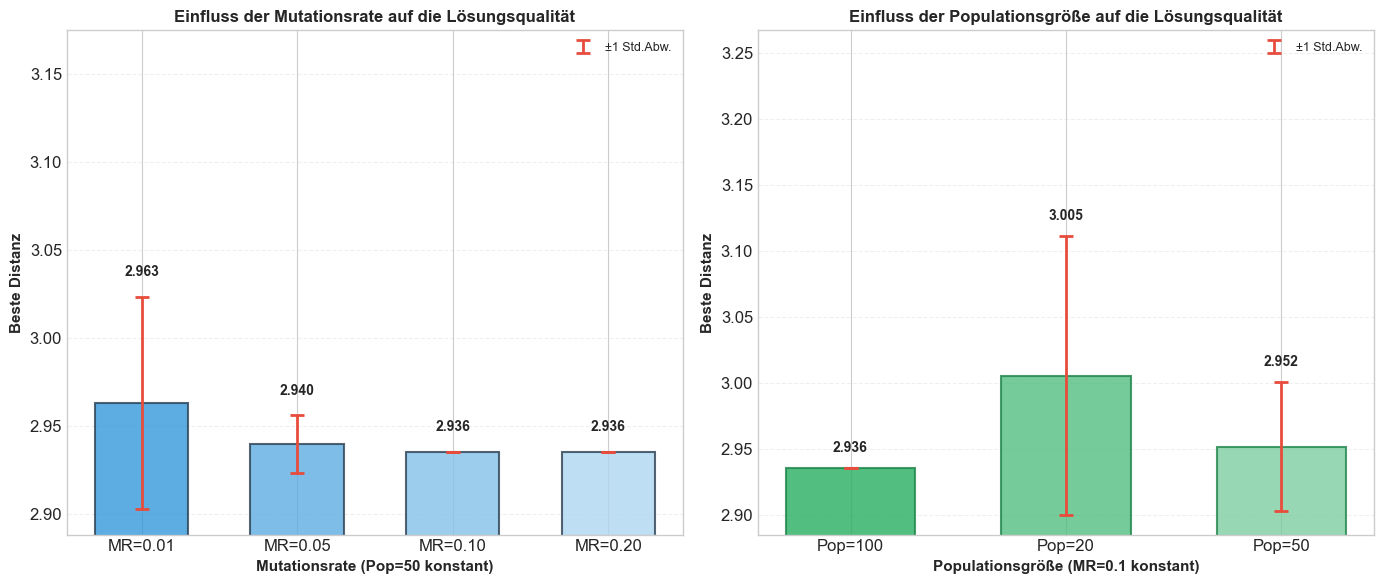

In [72]:
# Balkendiagramm mit Fehlerbalken erstellen (besser für Präsentationen)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Berechne Statistiken für Mutationsraten
mutation_stats = mutation_results.groupby('config')['best_distance'].agg(['mean', 'std'])
mutation_means = mutation_stats['mean'].values
mutation_stds = mutation_stats['std'].values
mutation_labels = mutation_stats.index.tolist()

# Balkendiagramm 1: Mutationsraten
x_pos1 = np.arange(len(mutation_labels))
bars1 = axes[0].bar(x_pos1, mutation_means, width=0.6, 
                     color=['#3498DB', '#5DADE2', '#85C1E9', '#AED6F1'], 
                     edgecolor='#2C3E50', linewidth=1.5, alpha=0.8)
# Fehlerbalken hinzufügen
axes[0].errorbar(x_pos1, mutation_means, yerr=mutation_stds, 
                 fmt='none', color='#E74C3C', linewidth=2, capsize=5, capthick=2,
                 label='±1 Std.Abw.')

# Werte auf den Balken anzeigen
for i, (mean_val, std_val) in enumerate(zip(mutation_means, mutation_stds)):
    axes[0].text(i, mean_val + std_val + 0.01, f'{mean_val:.3f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[0].set_xlabel('Mutationsrate (Pop=50 konstant)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Beste Distanz', fontsize=11, fontweight='bold')
axes[0].set_title('Einfluss der Mutationsrate auf die Lösungsqualität', fontweight='bold', fontsize=12)
axes[0].set_xticks(x_pos1)
axes[0].set_xticklabels(mutation_labels)
axes[0].grid(True, alpha=0.3, linestyle='--', axis='y')
axes[0].legend(loc='upper right', fontsize=9)
axes[0].set_ylim(bottom=min(mutation_means - mutation_stds) * 0.995)

# Berechne Statistiken für Populationsgrößen
popsize_stats = popsize_results.groupby('config')['best_distance'].agg(['mean', 'std'])
popsize_means = popsize_stats['mean'].values
popsize_stds = popsize_stats['std'].values
popsize_labels = popsize_stats.index.tolist()

# Balkendiagramm 2: Populationsgrößen
x_pos2 = np.arange(len(popsize_labels))
bars2 = axes[1].bar(x_pos2, popsize_means, width=0.6,
                    color=['#27AE60', '#52BE80', '#7DCEA0'], 
                    edgecolor='#1E8449', linewidth=1.5, alpha=0.8)
# Fehlerbalken hinzufügen
axes[1].errorbar(x_pos2, popsize_means, yerr=popsize_stds,
                fmt='none', color='#E74C3C', linewidth=2, capsize=5, capthick=2,
                label='±1 Std.Abw.')

# Werte auf den Balken anzeigen
for i, (mean_val, std_val) in enumerate(zip(popsize_means, popsize_stds)):
    axes[1].text(i, mean_val + std_val + 0.01, f'{mean_val:.3f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1].set_xlabel('Populationsgröße (MR=0.1 konstant)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Beste Distanz', fontsize=11, fontweight='bold')
axes[1].set_title('Einfluss der Populationsgröße auf die Lösungsqualität', fontweight='bold', fontsize=12)
axes[1].set_xticks(x_pos2)
axes[1].set_xticklabels(popsize_labels)
axes[1].grid(True, alpha=0.3, linestyle='--', axis='y')
axes[1].legend(loc='upper right', fontsize=9)
axes[1].set_ylim(bottom=min(popsize_means - popsize_stds) * 0.995)

plt.tight_layout()
save_figure(fig, '10_boxplots_parametervergleich.png')
plt.show()


Erstelle Konvergenzvergleich...
  → Grafik gespeichert: files/11_konvergenzvergleich_mutationsraten.png


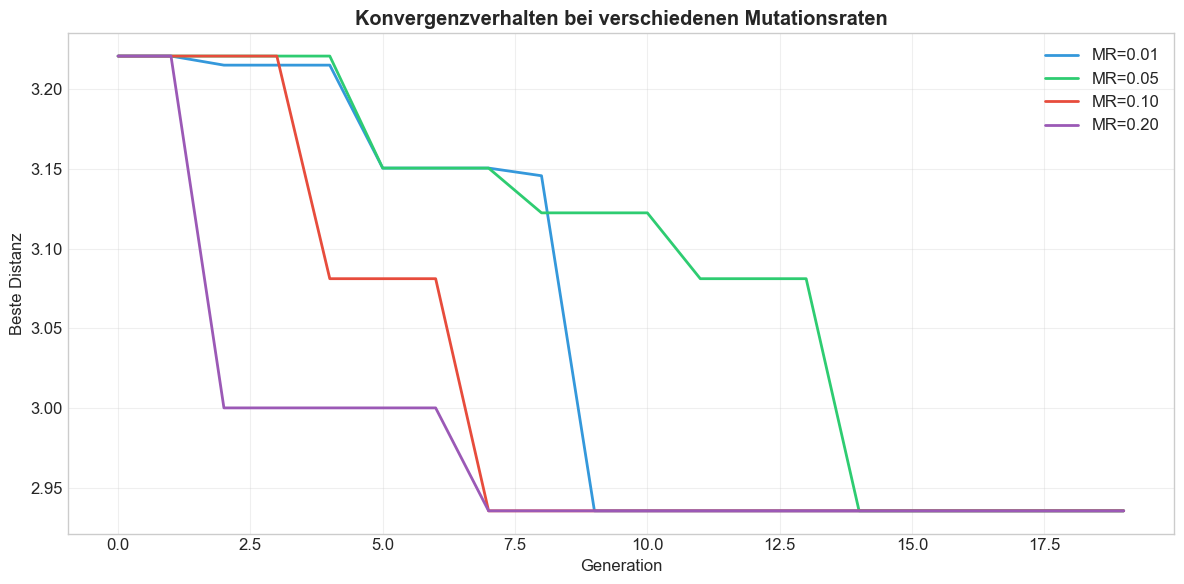

In [73]:
# Konvergenzvergleich für verschiedene Mutationsraten
print("Erstelle Konvergenzvergleich...")

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#3498DB', '#2ECC71', '#E74C3C', '#9B59B6']
for config, color in zip(mutation_configs, colors):
    # Einen repräsentativen Lauf durchführen mit Tracking (verwendet GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)
    random.seed(GLOBAL_SEED)
    result = run_evolution(
        city_coords, dist_matrix,
        pop_size=config['pop_size'],
        n_generations=N_GENERATIONS,
        mutation_rate=config['mutation_rate'],
        verbose=False,
        track_history=False
    )
    
    ax.plot(result['best_distances'], label=config['name'], color=color, linewidth=2)

ax.set_xlabel('Generation')
ax.set_ylabel('Beste Distanz')
ax.set_title('Konvergenzverhalten bei verschiedenen Mutationsraten', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_figure(fig, '11_konvergenzvergleich_mutationsraten.png')
plt.show()


### Interpretation der Ergebnisse

#### Hypothesen und Beobachtungen

**Hypothese 1: Mutationsrate**
> *"Eine höhere Mutationsrate verhindert das Feststecken in lokalen Optima."*

- **Zu niedrige Mutationsrate (0.01)**: Der Algorithmus kann in lokalen Optima stecken bleiben, da zu wenig Variation erzeugt wird.
- **Mittlere Mutationsrate (0.05-0.10)**: Gute Balance zwischen Exploration (neue Bereiche erkunden) und Exploitation (gute Lösungen verbessern).
- **Zu hohe Mutationsrate (0.20)**: Kann gute Lösungen zerstören und den Algorithmus zu einer Zufallssuche degradieren.

**Hypothese 2: Populationsgröße**
> *"Eine größere Population erhöht die Diversität und verbessert die Lösungsqualität."*

- **Kleine Population (20)**: Weniger Diversität, schnellere Konvergenz, aber evtl. schlechtere Endlösung.
- **Mittlere Population (50)**: Guter Kompromiss zwischen Rechenaufwand und Lösungsqualität.
- **Große Population (100)**: Mehr Diversität, aber auch höherer Rechenaufwand.

### Fazit

Der evolutionäre Algorithmus findet in der Regel gute (oft optimale) Lösungen für das 6-Städte-Problem. Die Wahl der Parameter hat signifikanten Einfluss auf:
1. **Konvergenzgeschwindigkeit**: Wie schnell wird eine gute Lösung gefunden?
2. **Lösungsqualität**: Wie gut ist die finale Lösung?
3. **Robustheit**: Wie konsistent sind die Ergebnisse über mehrere Läufe?


---

## Zusammenfassung: Prüfungsrelevante Konzepte

### Kernkonzepte des EA für das TSP

| Konzept | Beschreibung | TSP-Implementierung |
|---------|--------------|---------------------|
| **Encoding** | Darstellung einer Lösung | Permutation der Städte-Indizes |
| **Genotyp** | Interne Repräsentation | Array (z.B. Permutation der Indizes 0 bis n-1) |
| **Phänotyp** | Externe Interpretation | Route auf der Karte |
| **Fitness** | Güte einer Lösung | 1 / Gesamtdistanz |
| **Selektion** | Auswahl der Eltern | Tournament Selection |
| **Mutation** | Zufällige Veränderung | Invertierende Mutation |
| **Rekombination** | Kombination von Eltern | Order Crossover (OX) |
| **Elitismus** | Bewahrung guter Lösungen | Top-n bleiben erhalten |

### Wichtige Merksätze

1. **NP-Härte**: Das TSP kann nicht in polynomieller Zeit exakt gelöst werden → Heuristiken nötig
2. **Permutationsencoding**: Garantiert gültige Lösungen (jede Stadt genau einmal)
3. **Selektionsdruck**: Balance zwischen Exploration und Exploitation ist entscheidend
4. **Statistische Absicherung**: Mindestens 30 Läufe für valide Aussagen

### Laufende Analogie

> *Der EA ist wie ein digitaler Logistikplaner: Statt alle Routen durchzuprobieren, lässt er "Versuchsrouten" gegeneinander antreten. Die fittesten paaren sich (Crossover), kleine Irrtümer (Mutation) führen zu neuen Entdeckungen.*

---

**Ende des Notebooks** | Erstellt für Computational Intelligence - Evolutionäre Algorithmen
